# Which Risk Factors Accurately Predict the Presence of Heart Disease?

## Introduction

Heart disease is any condition that affects the heart. While there are many different types of heart disease, the most common is coronary artery disease, also known as ischemic heart disease, which occurs when there is decreased blood flow to the heart, causing what is commonly known as a heart attack. In Canada, heart disease is the second leading cause of death, with about 1 in 12 Canadian adults over the age of 20 being diagnosed. Heart disease can be caused by uncontrollable risk factors like age and sex, as well as other risk factors like blood pressure and cholesterol. In this study, we attempt to determine which risk factors accurately predict the presence of heart disease using classification. We use the heart disease dataset for Cleveland from the University of California, Irvine Machine Learning Repository (https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data). This dataset contains 14 risk factors, including *num* (diagnosis of heart disease), which is what we are attempting to predict.

## Preliminary exploratory data analysis

In [1]:
# load in the libraries

library(repr)
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

First, we need to load in the dataset. We used the `read_csv()` function to read the processed dataset for Cleveland.

No column names were provided in the original dataset, so we added them using the `colnames()` function.

Then, we used the `as_factor()` function to factorize binary variables (sex, fbs - fasting blood sugar, exang - exercise induced angina). For example, sex is a binary variable (male or female), so we factorized it such that 0 represents female and 1 represents male.

In [22]:
heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")

colnames(heart_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

heart_data <- heart_data |>
        mutate(sex = as.factor(sex), 
               #age = as.factor(age),
           num = as.factor(num), 
           slope = as.factor(slope),
           cp = as.factor(cp),
           #trestbps = as.factor(trestbps),
           #chol = as.factor(chol),
           fbs = as.factor(fbs),
           restecg = as.factor(restecg),
         #  thalach = as.factor(thalach),
           exang = as.factor(exang),
         #  oldpeak = as.factor(oldpeak),
           ca = as.factor(ca),
           thal = as.factor(thal),
          )


New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Before performing exploratory data analysis, we must partition `heart_data` into a training (75%) and testing (25%) set using the `tinymodels`.

We first use `initial_split` to split the data, then we pass it to the respective `heart_train` and `heart_test` objects to create the training and testing set.

In [48]:
heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)


Using only the training data, we then cleaned and wrangled the data into a tidy format.

We summarized the data in a table that contains the means of predictor variables/risk factors (age, trestbps - resting blood pressure, chol - cholesterol, thalach - max heart rate).

In [24]:
heart_avg <- heart_train |>
    select(sex, age, trestbps, chol, thalach) |>
    pivot_longer(cols = age:thalach,
                 names_to = "predictor",
                 values_to = "avg") |>
    group_by(sex, predictor) |>
    summarize(avg = mean(avg, na.rm = TRUE))

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


Using only the training data again, we visualize the data with a plot to compare the distributions of each of the predictor variables/risk factors between females and males.

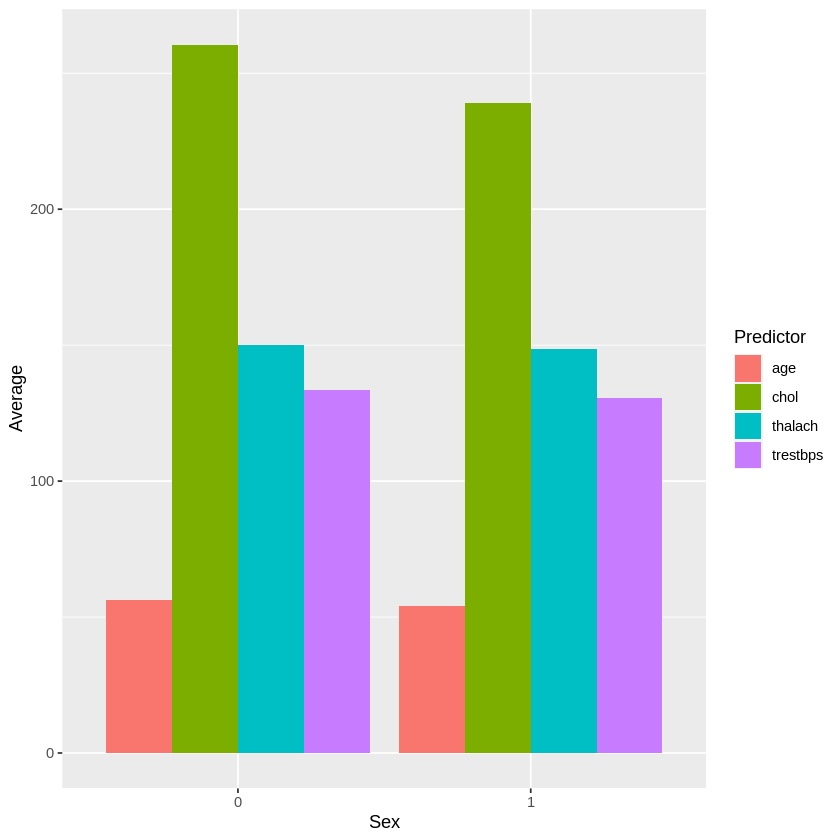

In [25]:
predictor_plot <- heart_avg |>
    ggplot(aes(x = sex, y = avg, fill = predictor)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(x = "Sex", y = "Average", fill = "Predictor")
predictor_plot

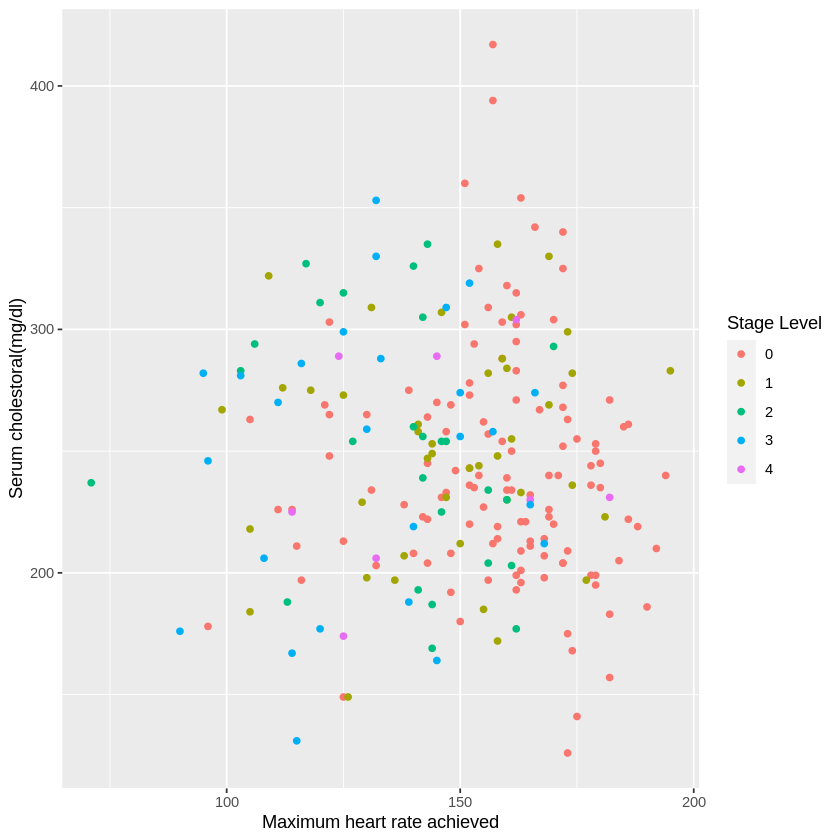

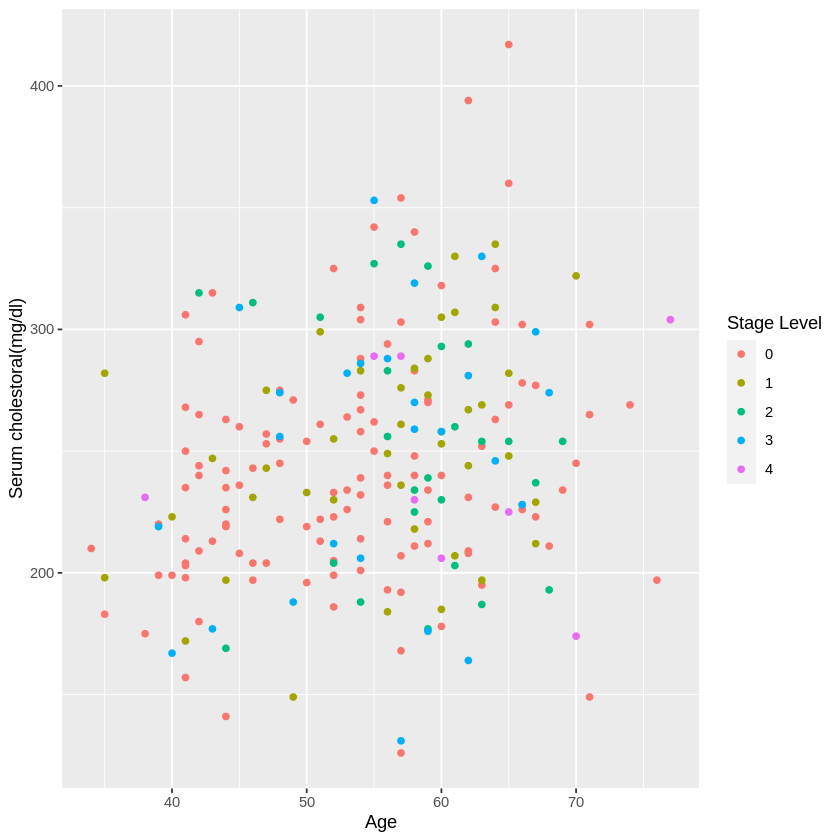

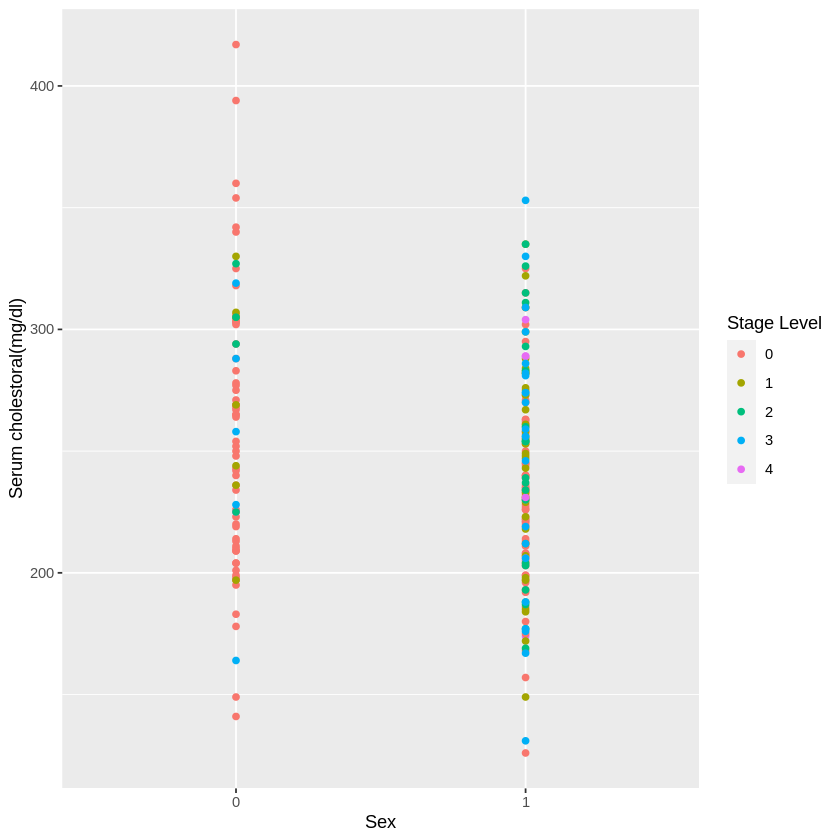

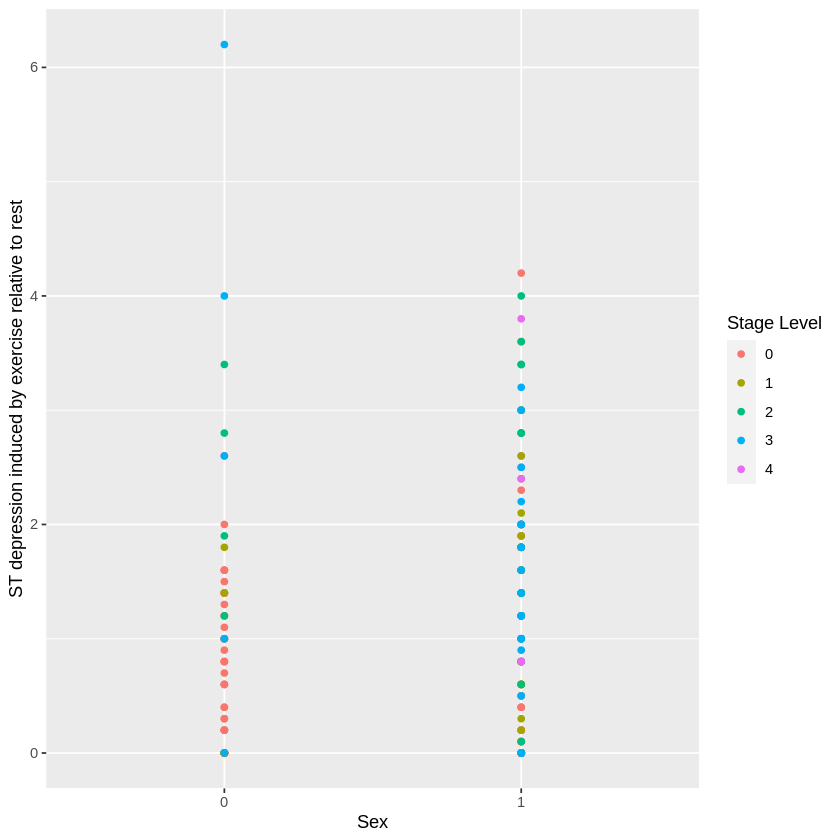

In [49]:
thalach_chol <- heart_train |>
                ggplot(aes(x = thalach, y = chol, colour = num)) +
                geom_point()+
                labs(x = "Maximum heart rate achieved", y = "Serum cholestoral(mg/dl)", colour = "Stage Level")

thalach_chol
age_chol <- heart_train |>
                ggplot(aes(x = age, y = chol, colour = num)) +
                geom_point()+
                labs(x = "Age", y = "Serum cholestoral(mg/dl)", colour = "Stage Level")
age_chol 
sex_chol <- heart_train |>
                ggplot(aes(x = sex, y = chol, colour = num)) +
                geom_point()+
                labs(x = "Sex", y = "Serum cholestoral(mg/dl)", colour = "Stage Level")
sex_chol 
sex_oldpeak <- heart_train |>
                ggplot(aes(x = sex, y = oldpeak, colour = num)) +
                geom_point()+
                labs(x = "Sex", y = "ST depression induced by exercise relative to rest", colour = "Stage Level")
sex_oldpeak


## Methods

#### - Explain how you will conduct either your data analysis and which variables/columns you will use. 
We have found several usable predictors based on the result from plots, we showed part of them above. Finally, we decided to use sex, age, cp, chol, thalach, trestbps and oldpeak as our predictors. We chose them because these variables showed strong relations to stage level based on graphs. 
The learning algorithm that we will use is K-Nearest Neighbors algorithm, we will set predictors and use training data come out a classifier.
#### - Describe at least one way that you will visualize the results
Firstly, we will put testing set into our classifier. Then we will use scatter plot to visualize the result of our classifier and check the predictions.

## Expected outcomes and significance

#### - What do you expect to find?
We expect to come out with a classifier, which consumes the variable of a person's information, which are sex, age, trestbps, chol ...) and produces the stage level of heart disease. We expect this model has an accuracy of 80%+.
#### - What impact could such findings have?
This model will be helpful to medical workers to predict the stage level of heart disease before they do formal medical checks and treatment. These findings also might contribute to the medical industry with this research on heart disease, even though it might be small contributions.
#### - What future questions could this lead to?
An obvious future question could be how to increase the accuracy of this model. 
The other one is if we only have a few figures of a patient in a real situation. As we know, getting a patient's figures needs time, but sometimes we do not have enough time for testing and get data of all predictors (e.g. the patient is in a life- -death timing), how can we upgrade our model so that it can do the prediction with fewer figures.